In [1]:
def limpieza(dataset):
    
    df = dataset.copy()

    df.rename(columns={'default payment next month':'default'}, inplace=True)

    df.drop(columns='ID', inplace=True)

    df = df[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]

    df['EDUCATION'] = df['EDUCATION'].apply(lambda x: 4 if x > 4 else x)

    df['SEX'] = df['SEX'].astype('category')
    df['EDUCATION'] = df['EDUCATION'].astype('category')
    df['MARRIAGE'] = df['MARRIAGE'].astype('category')
    df['PAY_0'] = df['PAY_0'].astype('category')
    df['PAY_2'] = df['PAY_2'].astype('category')
    df['PAY_3'] = df['PAY_3'].astype('category')
    df['PAY_4'] = df['PAY_4'].astype('category')
    df['PAY_5'] = df['PAY_5'].astype('category')
    df['PAY_6'] = df['PAY_6'].astype('category')
    df['default'] = df['default'].astype('category')

    return df

In [2]:
import glob
import pandas as pd

test_file, train_file = glob.glob(f'../files/input/*')

def load_data(directory):
    df = pd.read_csv(directory)
    df = limpieza(dataset=df)
    return df

test = load_data(directory=test_file)
train = load_data(directory=train_file)

In [3]:
def division_dataset(dataset):

    df = dataset.copy()
    x  = df.drop(columns='default')
    y  = df['default']

    return x, y

x_train, y_train = division_dataset(train)
x_test, y_test = division_dataset(test)

In [ ]:
from sklearn.utils import shuffle

class_0 = x_train[y_train == 0]
class_1 = x_train[y_train == 1]

class_0_sample = class_0.sample(frac=0.3, random_state=666)

x_train_reducted = pd.concat([class_0_sample, class_1])
y_train_reducted = pd.concat([
    pd.Series([0] * len(class_0_sample), index=class_0_sample.index),
    pd.Series([1] * len(class_1), index=class_1.index)
])

x_train_reducted, y_train_reducted = shuffle(x_train_reducted, y_train_reducted, random_state=666)

y_train_reducted.value_counts()

0    4868
1    4725
Name: count, dtype: int64

In [9]:
class_0 = x_test[y_test == 0]
class_1 = x_test[y_test == 1]

class_0_sample = class_0.sample(frac=0.3, random_state=666)

x_test_reducted = pd.concat([class_0_sample, class_1])
y_test_reducted = pd.concat([
    pd.Series([0] * len(class_0_sample), index=class_0_sample.index),
    pd.Series([1] * len(class_1), index=class_1.index)
])

x_test_reducted, y_test_reducted = shuffle(x_test_reducted, y_test_reducted, random_state=666)

y_test_reducted.value_counts()

0    2122
1    1906
Name: count, dtype: int64

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.svm import SVC

In [7]:
categorical_columns = x_train.select_dtypes(include='category').columns.to_list()

column_transformer = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop='if_binary', max_categories=6, handle_unknown='infrequent_if_exist', sparse_output=False), categorical_columns)
    ],
    remainder=StandardScaler() 
)

pipe = Pipeline(steps=
    [
        ('preprocessor', column_transformer),
        ('dimensionality_reducter', PCA(n_components=2)),
        ('classifier', SVC())
    ]
)

pipe.fit(x_train_reducted, y_train_reducted)

c:\Users\arica\OneDrive\Analìtica predictiva\2024-2-LAB-03-prediccion-del-default-usando-svc-Felipe-Arikpa\.venv\lib\site-packages\sklearn\compose\_column_transformer.py:1651: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist',
                                                                max_categories=6,
                                                                sparse_output=False),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE', 'PAY_0', 'PAY_2',
                                                   'PAY_3', 'PAY_4', 'PAY_5',
                                                   'PAY_6'])])),
                ('dimensionality_reducter', PCA(n_components=2)),
                ('classifier', SVC())])

In [11]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score

y_pred_train = pipe.predict(x_train_reducted)
y_pred_test = pipe.predict(x_test_reducted)

print('balanced accuracy train:', balanced_accuracy_score(y_train_reducted, y_pred_train))
print('balanced accuracy test:', balanced_accuracy_score(y_test_reducted, y_pred_test))
print('precision score train:', precision_score(y_train_reducted, y_pred_train))
print('precision score test:', precision_score(y_test_reducted, y_pred_test))
print('recall score train:', recall_score(y_train_reducted, y_pred_train))
print('recall score test:', recall_score(y_test_reducted, y_pred_test))
print('f1 score train:', f1_score(y_train_reducted, y_pred_train))
print('f1 score test:', f1_score(y_test_reducted, y_pred_test))

balanced accuracy train: 0.5805430345241356
balanced accuracy test: 0.5851018115322119
precision score train: 0.5730969760166841
precision score test: 0.5574174470182356
recall score train: 0.5815873015873015
recall score test: 0.593389296956978
f1 score train: 0.5773109243697478
f1 score test: 0.5748411689961881


In [12]:
from sklearn.metrics import confusion_matrix

def matriz(yt, yp):
    matrix = confusion_matrix(y_true=yt, y_pred=yp)
    return matrix

matrix_train = confusion_matrix_df = pd.DataFrame(
    matriz(yt=y_train_reducted, yp=pipe.predict(x_train_reducted)),
    index=["N (Clase Real Negativa)", "P (Clase Real Positiva)"],
    columns=["PN (Predicción Negativa)", "PP (Predicción Positiva)"]
)

matrix_test = confusion_matrix_df = pd.DataFrame(
    matriz(yt=y_test_reducted, yp=pipe.predict(x_test_reducted)),
    index=["N (Clase Real Negativa)", "P (Clase Real Positiva)"],
    columns=["PN (Predicción Negativa)", "PP (Predicción Positiva)"]
)

display(
    matrix_train,
    matrix_test
)

,PN (Predicción Negativa),PP (Predicción Positiva)
N (Clase Real Negativa),2821,2047
P (Clase Real Positiva),1977,2748


,PN (Predicción Negativa),PP (Predicción Positiva)
N (Clase Real Negativa),1224,898
P (Clase Real Positiva),775,1131


In [13]:
columns_transformer = pipe.named_steps['preprocessor']

x_transformed = columns_transformer.transform(x_train_reducted)
x_transformed = pd.DataFrame(x_transformed, columns=columns_transformer.get_feature_names_out())

print('columnas dataset original:', len(train.columns))
print('columnas dataset transformado:', len(x_transformed.columns))

columnas dataset original: 24
columnas dataset transformado: 58


In [14]:
pca = pipe.named_steps['dimensionality_reducter']
x_reduced = pca.transform(x_transformed)

pca_dataset = pd.DataFrame(
        x_reduced,
        columns= pca.get_feature_names_out()
)

pca_dataset

c:\Users\arica\OneDrive\Analìtica predictiva\2024-2-LAB-03-prediccion-del-default-usando-svc-Felipe-Arikpa\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


,pca0,pca1
0,-0.096078,-0.445630
1,7.062238,-0.763826
2,0.822338,0.189301
3,-1.755176,0.685891
4,-1.717581,0.551810
...,...,...
9588,0.621488,-1.071121
9589,-0.834310,-0.453559
9590,-1.833375,0.725879
9591,-1.056420,-0.546102


In [15]:
varianza_explicada = pca.explained_variance_ratio_ * 100
varianza_explicada = pd.DataFrame(
    {
        'Componente': pca.get_feature_names_out(),
        'Varianza Explicada (%)': varianza_explicada
    }
)

varianza_explicada['Varianza Acumulada (%)'] = varianza_explicada['Varianza Explicada (%)'].cumsum()
varianza_explicada['Varianza Explicada (%)'] = varianza_explicada['Varianza Explicada (%)'].apply(lambda x:f'{x:.2f}')
varianza_explicada

,Componente,Varianza Explicada (%),Varianza Acumulada (%)
0,pca0,31.87,31.874159
1,pca1,10.95,42.826201


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np

def custom_metric(yt, yp):
    precision = precision_score(y_true=yt, y_pred=yp)
    balanced = balanced_accuracy_score(y_true=yt, y_pred=yp)
    if precision >= 0.691 and balanced >= 0.661:
        return precision + balanced
    else:
        return balanced

scoring = make_scorer(custom_metric)

param_grid = {
    'classifier__C': [1, 5, 10, 20, 40, 70, 100],
    #'classifier__C': np.arange(65, 76, 3),
    'classifier__gamma': [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
    #'classifier__gamma': np.arange(0.6, 1.1, 0.2),
}

model = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=4,
    scoring=scoring,
    n_jobs=-1,
    refit=True,
    verbose=1
)

model.fit(x_train_reducted, y_train_reducted)

Fitting 4 folds for each of 49 candidates, totalling 196 fits


c:\Users\arica\OneDrive\Analìtica predictiva\2024-2-LAB-03-prediccion-del-default-usando-svc-Felipe-Arikpa\.venv\lib\site-packages\sklearn\compose\_column_transformer.py:1651: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='infrequent_if_exist',
                                                                                       max_categories=6,
                                                                                       sparse_output=False),
                                                                         ['SEX',
                                                                          'EDUCATION',
                                                                          'MARRIAGE',
                                                                          'PAY_0',
                                                                          'PAY_2',
                                                                          'PAY_3',
                                                                          'PAY_4',
                                                                          'PAY_5',
                                                                          'PAY_6'])])),
                                       ('dimensionality_reducter',
                                        PCA(n_components=2)),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid={'classifier__C': [1, 5, 10, 20, 40, 70, 100],
                         'classifier__gamma': [0.01, 0.03, 0.06, 0.1, 0.3, 0.6,
                                               1]},
             scoring=make_scorer(custom_metric, response_method='predict'),
             verbose=1)

In [18]:
y_pred_train = model.predict(x_train_reducted)
y_pred_test = model.predict(x_test_reducted)

print('mejores parámetros encontrados:', model.best_params_)
print()
print('balanced accuracy train:', balanced_accuracy_score(y_train_reducted, y_pred_train))
print('balanced accuracy test:', balanced_accuracy_score(y_test_reducted, y_pred_test))
print('precision score train:', precision_score(y_train_reducted, y_pred_train))
print('precision score test:', precision_score(y_test_reducted, y_pred_test))
print('recall score train:', recall_score(y_train_reducted, y_pred_train))
print('recall score test:', recall_score(y_test_reducted, y_pred_test))
print('f1 score train:', f1_score(y_train_reducted, y_pred_train))
print('f1 score test:', f1_score(y_test_reducted, y_pred_test))
print()
print('score train:', model.score(x_train_reducted, y_train_reducted))
print('score test:', model.score(x_test_reducted, y_test_reducted))

mejores parámetros encontrados: {'classifier__C': 1, 'classifier__gamma': 1}

balanced accuracy train: 0.5972661110458974
balanced accuracy test: 0.5929843057243707
precision score train: 0.5906604964240639
precision score test: 0.5663672654690619
recall score train: 0.5942857142857143
recall score test: 0.5954879328436516
f1 score train: 0.5924675598691845
f1 score test: 0.5805626598465473

score train: 0.5972661110458974
score test: 0.5929843057243707


In [19]:
def matriz2(yt, yp):
    matrix = confusion_matrix(y_true=yt, y_pred=yp)
    return matrix

matrix_train = confusion_matrix_df = pd.DataFrame(
    matriz2(yt=y_train_reducted, yp=model.predict(x_train_reducted)),
    index=["N (Clase Real Negativa)", "P (Clase Real Positiva)"],
    columns=["PN (Predicción Negativa)", "PP (Predicción Positiva)"]
)

matrix_test = confusion_matrix_df = pd.DataFrame(
    matriz2(yt=y_test_reducted, yp=model.predict(x_test_reducted)),
    index=["N (Clase Real Negativa)", "P (Clase Real Positiva)"],
    columns=["PN (Predicción Negativa)", "PP (Predicción Positiva)"]
)

display(
    matrix_train,
    matrix_test
)

,PN (Predicción Negativa),PP (Predicción Positiva)
N (Clase Real Negativa),2922,1946
P (Clase Real Positiva),1917,2808


,PN (Predicción Negativa),PP (Predicción Positiva)
N (Clase Real Negativa),1253,869
P (Clase Real Positiva),771,1135


In [20]:
results = pd.DataFrame(model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)

results = results[
    [
        'param_classifier__C',
        'param_classifier__gamma',
        'mean_test_score',
        'std_test_score',
        'rank_test_score'
    ]
].sort_values('mean_test_score', ascending=False).reset_index(drop=True)

results.head(20)

,param_classifier__C,param_classifier__gamma,mean_test_score,std_test_score,rank_test_score
0,1,1.00,0.584398,0.005641,1
1,5,0.60,0.583689,0.007091,2
2,10,0.60,0.582339,0.006537,3
3,1,0.60,0.581867,0.005691,4
4,70,0.30,0.581712,0.008271,5
5,40,0.30,0.581523,0.007264,6
6,100,0.30,0.581376,0.007905,7
7,100,1.00,0.581231,0.006039,8
8,5,1.00,0.581007,0.005123,9
9,20,0.30,0.580457,0.006198,10


In [21]:
svm = pipe.named_steps['classifier']
print('Valor de gamma:', svm._gamma)

Valor de gamma: 0.12011616351355124


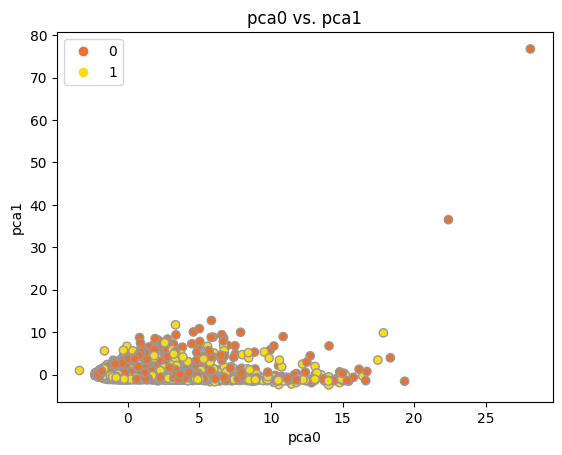

In [25]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots()

scatter = ax.scatter(
    x = pca_dataset.iloc[:, 0],
    y = pca_dataset.iloc[:, 1],
    c = y_train_reducted,
    zorder = 2,
    edgecolors = '#999999',
    cmap = ListedColormap(['#E67332', '#FADB15'])
)

ax.set_title('pca0 vs. pca1')
ax.set_xlabel('pca0')
ax.set_ylabel('pca1')
ax.legend(
    handles = scatter.legend_elements()[0],
    labels = list(y_train_reducted.unique())
)

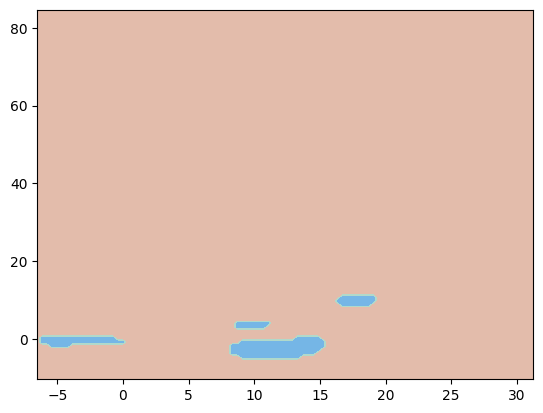

In [24]:
min_pca0 = min(pca_dataset.iloc[:, 0])
max_pca0 = max(pca_dataset.iloc[:, 0])
min_pca1 = min(pca_dataset.iloc[:, 1])
max_pca1 = max(pca_dataset.iloc[:, 1])

margin_pca0 = (max_pca0 - min_pca0) * 0.1
margin_pca1 = (max_pca1 - min_pca1) * 0.1

x = np.linspace(min_pca0 - margin_pca0, max_pca0 + margin_pca0, 100)
y = np.linspace(min_pca1 - margin_pca1, max_pca1 + margin_pca1, 100)

X, Y = np.meshgrid(x, y)

Z = svm.predict(np.c_[X.ravel(), Y.ravel()]).reshape(X.shape)

fig, ax = plt.subplots()
ax.contourf(X, Y, Z,
            levels = 2,
            colors = ['#E3BCAB', '#B0D9CB', '#75B6E6'],
            zorder = 0
            )